In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
from math import sqrt
import numpy as np
import math
import scipy
import scipy.ndimage
from skimage.morphology import skeletonize as skelt
from skimage.morphology import thin
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
import glob
import os

# PreProcessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
finger_image = plt.imread('./drive/MyDrive/all_data/A_f0005_03.png')

### Normalisation

In [4]:
def normalize_pixel(x, v0, v, m, m0):
    """
    From Handbook of Fingerprint Recognition pg 133
    Normalize job used by Hong, Wan and Jain(1998)
    similar to https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf equation 21
    :param x: pixel value
    :param v0: desired variance
    :param v: global image variance
    :param m: global image mean
    :param m0: desired mean
    :return: normilized pixel
    """
    dev_coeff = sqrt((v0 * ((x - m)**2)) / v)
    return m0 + dev_coeff if x > m else m0 - dev_coeff

def normalize(im, m0, v0):
    m = np.mean(im)
    v = np.std(im) ** 2
    (y, x) = im.shape
    normilize_image = im.copy()
    for i in range(x):
        for j in range(y):
            normilize_image[j, i] = normalize_pixel(im[j, i], v0, v, m, m0)

    return normilize_image

### Segmentation

In [5]:
def normalise(img):
    return (img - np.mean(img))/(np.std(img))


def create_segmented_and_variance_images(im, w, threshold=.2):
    """
    Returns mask identifying the ROI. Calculates the standard deviation in each image block and threshold the ROI
    It also normalises the intesity values of
    the image so that the ridge regions have zero mean, unit standard
    deviation.
    :param im: Image
    :param w: size of the block
    :param threshold: std threshold
    :return: segmented_image
    """
    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    segmented_image = im.copy()
    mask = np.ones_like(im)

    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # apply threshold
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    # normalize segmented image
    segmented_image *= mask
    im = normalise(im)
    mean_val = np.mean(im[mask==0])
    std_val = np.std(im[mask==0])
    norm_img = (im - mean_val)/(std_val)

    return segmented_image, norm_img, mask

### Orientation Map

In [6]:
def calculate_angles(im, W, smoth=False):
    """
    anisotropy orientation estimate, based on equations 5 from:
    https://pdfs.semanticscholar.org/6e86/1d0b58bdf7e2e2bb0ecbf274cee6974fe13f.pdf
    :param im:
    :param W: int width of the ridge
    :return: array
    """
    j1 = lambda x, y: 2 * x * y
    j2 = lambda x, y: x ** 2 - y ** 2
    j3 = lambda x, y: x ** 2 + y ** 2

    (y, x) = im.shape

    sobelOperator = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ySobel = np.array(sobelOperator).astype(np.int)
    xSobel = np.transpose(ySobel).astype(np.int)

    result = [[] for i in range(1, y, W)]

    Gx_ = cv.filter2D(im/125,-1, ySobel)*125
    Gy_ = cv.filter2D(im/125,-1, xSobel)*125

    for j in range(1, y, W):
        for i in range(1, x, W):
            nominator = 0
            denominator = 0
            for l in range(j, min(j + W, y - 1)):
                for k in range(i, min(i + W , x - 1)):
                    Gx = round(Gx_[l, k])  # horizontal gradients at l, k
                    Gy = round(Gy_[l, k])  # vertial gradients at l, k
                    nominator += j1(Gx, Gy)
                    denominator += j2(Gx, Gy)

            # nominator = round(np.sum(Gy_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            # denominator = round(np.sum(Gx_[j:min(j + W, y - 1), i:min(i + W , x - 1)]))
            if nominator or denominator:
                angle = (math.pi + math.atan2(nominator, denominator)) / 2
                orientation = np.pi/2 + math.atan2(nominator,denominator)/2
                result[int((j-1) // W)].append(angle)
            else:
                result[int((j-1) // W)].append(0)

            # segment image
            # focus_img = im[j:min(j + W, y - 1), i:min(i + W , x - 1)]
            # segmentator = -1 if segmentator/W*W < np.max(focus_img)*

    result = np.array(result)

    if smoth:
        result = smooth_angles(result)

    return result


def gauss(x, y):
    ssigma = 1.0
    return (1 / (2 * math.pi * ssigma)) * math.exp(-(x * x + y * y) / (2 * ssigma))


def kernel_from_function(size, f):
    kernel = [[] for i in range(0, size)]
    for i in range(0, size):
        for j in range(0, size):
            kernel[i].append(f(i - size / 2, j - size / 2))
    return kernel


def smooth_angles(angles):
    """
    reference: https://airccj.org/CSCP/vol7/csit76809.pdf pg91
    Practically, it is possible to have a block so noisy that the directional estimate is completely false.
    This then causes a very large angular variation between two adjacent blocks. However, a
    fingerprint has some directional continuity, such a variation between two adjacent blocks is then
    representative of a bad estimate. To eliminate such discontinuities, a low-pass filter is applied to
    the directional board.
    :param angles:
    :return:
    """
    angles = np.array(angles)
    cos_angles = np.cos(angles.copy()*2)
    sin_angles = np.sin(angles.copy()*2)

    kernel = np.array(kernel_from_function(5, gauss))

    cos_angles = cv.filter2D(cos_angles/125,-1, kernel)*125
    sin_angles = cv.filter2D(sin_angles/125,-1, kernel)*125
    smooth_angles = np.arctan2(sin_angles, cos_angles)/2

    return smooth_angles


def get_line_ends(i, j, W, tang):
    if -1 <= tang and tang <= 1:
        begin = (i, int((-W/2) * tang + j + W/2))
        end = (i + W, int((W/2) * tang + j + W/2))
    else:
        begin = (int(i + W/2 + W/(2 * tang)), j + W//2)
        end = (int(i + W/2 - W/(2 * tang)), j - W//2)
    return (begin, end)


def visualize_angles(im, mask, angles, W):
    (y, x) = im.shape
    result = cv.cvtColor(np.zeros(im.shape, np.uint8), cv.COLOR_GRAY2RGB)
    mask_threshold = (W-1)**2
    for i in range(1, x, W):
        for j in range(1, y, W):
            radian = np.sum(mask[j - 1:j + W, i-1:i+W])
            if radian > mask_threshold:
                tang = math.tan(angles[(j - 1) // W][(i - 1) // W])
                (begin, end) = get_line_ends(i, j, W, tang)
                cv.line(result, begin, end, color=150)

    cv.resize(result, im.shape, result)
    return result

### Frequency Map

In [7]:
def frequest(im, orientim, kernel_size, minWaveLength, maxWaveLength):
    """
    Based on https://pdfs.semanticscholar.org/ca0d/a7c552877e30e1c5d87dfcfb8b5972b0acd9.pdf pg.14
    Function to estimate the fingerprint ridge frequency within a small block
    of a fingerprint image.
    An image block the same size as im with all values set to the estimated ridge spatial frequency.  If a
    ridge frequency cannot be found, or cannot be found within the limits set by min and max Wavlength freqim is set to zeros.
    """
    rows, cols = np.shape(im)
    
    # Find mean orientation within the block. This is done by averaging the
    # sines and cosines of the doubled angles before reconstructing the angle again.
    cosorient = np.cos(2*orientim) # np.mean(np.cos(2*orientim))
    sinorient = np.sin(2*orientim) # np.mean(np.sin(2*orientim))
    block_orient = math.atan2(sinorient,cosorient)/2
    
    # Rotate the image block so that the ridges are vertical
    rotim = scipy.ndimage.rotate(im,block_orient/np.pi*180 + 90,axes=(1,0),reshape = False,order = 3,mode = 'nearest')

    # Now crop the image so that the rotated image does not contain any invalid regions.
    cropsze = int(np.fix(rows/np.sqrt(2)))
    offset = int(np.fix((rows-cropsze)/2))
    rotim = rotim[offset:offset+cropsze][:,offset:offset+cropsze]

    # Sum down the columns to get a projection of the grey values down the ridges.
    ridge_sum = np.sum(rotim, axis = 0)
    dilation = scipy.ndimage.grey_dilation(ridge_sum, kernel_size, structure=np.ones(kernel_size))
    ridge_noise = np.abs(dilation - ridge_sum); peak_thresh = 2;
    maxpts = (ridge_noise < peak_thresh) & (ridge_sum > np.mean(ridge_sum))
    maxind = np.where(maxpts)
    _, no_of_peaks = np.shape(maxind)
    
    # Determine the spatial frequency of the ridges by dividing the
    # distance between the 1st and last peaks by the (No of peaks-1). If no
    # peaks are detected, or the wavelength is outside the allowed bounds, the frequency image is set to 0
    if(no_of_peaks<2):
        freq_block = np.zeros(im.shape)
    else:
        waveLength = (maxind[0][-1] - maxind[0][0])/(no_of_peaks - 1)
        if waveLength>=minWaveLength and waveLength<=maxWaveLength:
            freq_block = 1/np.double(waveLength) * np.ones(im.shape)
        else:
            freq_block = np.zeros(im.shape)
    return(freq_block)


def ridge_freq(im, mask, orient, block_size, kernel_size, minWaveLength, maxWaveLength):
    # Function to estimate the fingerprint ridge frequency across a
    # fingerprint image.
    rows,cols = im.shape
    freq = np.zeros((rows,cols))

    for row in range(0, rows - block_size, block_size):
        for col in range(0, cols - block_size, block_size):
            image_block = im[row:row + block_size][:, col:col + block_size]
            angle_block = orient[row // block_size][col // block_size]
            if angle_block:
                freq[row:row + block_size][:, col:col + block_size] = frequest(image_block, angle_block, kernel_size,
                                                                               minWaveLength, maxWaveLength)

    freq = freq*mask
    freq_1d = np.reshape(freq,(1,rows*cols))
    ind = np.where(freq_1d>0)
    ind = np.array(ind)
    ind = ind[1,:]
    non_zero_elems_in_freq = freq_1d[0][ind]
    medianfreq = np.median(non_zero_elems_in_freq) * mask

    return medianfreq

### Gabor Filter

In [8]:
def gabor_filter(im, orient, freq, kx=0.65, ky=0.65):
    """
    Gabor filter is a linear filter used for edge detection. Gabor filter can be viewed as a sinusoidal plane of
    particular frequency and orientation, modulated by a Gaussian envelope.
    :param im:
    :param orient:
    :param freq:
    :param kx:
    :param ky:
    :return:
    """
    angleInc = 3
    im = np.double(im)
    rows, cols = im.shape
    return_img = np.zeros((rows,cols))

    # Round the array of frequencies to the nearest 0.01 to reduce the
    # number of distinct frequencies we have to deal with.
    freq_1d = freq.flatten()
    frequency_ind = np.array(np.where(freq_1d>0))
    non_zero_elems_in_freq = freq_1d[frequency_ind]
    non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq*100)))/100
    unfreq = np.unique(non_zero_elems_in_freq)

    # Generate filters corresponding to these distinct frequencies and
    # orientations in 'angleInc' increments.
    sigma_x = 1/unfreq*kx
    sigma_y = 1/unfreq*ky
    block_size = np.round(3*np.max([sigma_x,sigma_y]))
    array = np.linspace(-block_size,block_size,int((2*block_size + 1)))
    x, y = np.meshgrid(array, array)

    # gabor filter equation
    reffilter = np.exp(-(((np.power(x,2))/(sigma_x*sigma_x) + (np.power(y,2))/(sigma_y*sigma_y)))) * np.cos(2*np.pi*unfreq[0]*x)
    filt_rows, filt_cols = reffilter.shape
    gabor_filter = np.array(np.zeros((180//angleInc, filt_rows, filt_cols)))

    # Generate rotated versions of the filter.
    for degree in range(0,180//angleInc):
        rot_filt = scipy.ndimage.rotate(reffilter,-(degree*angleInc + 90),reshape = False)
        gabor_filter[degree] = rot_filt

    # Convert orientation matrix values from radians to an index value that corresponds to round(degrees/angleInc)
    maxorientindex = np.round(180/angleInc)
    orientindex = np.round(orient/np.pi*180/angleInc)
    for i in range(0,rows//16):
        for j in range(0,cols//16):
            if(orientindex[i][j] < 1):
                orientindex[i][j] = orientindex[i][j] + maxorientindex
            if(orientindex[i][j] > maxorientindex):
                orientindex[i][j] = orientindex[i][j] - maxorientindex

    # Find indices of matrix points greater than maxsze from the image boundary
    block_size = int(block_size)
    valid_row, valid_col = np.where(freq>0)
    finalind = \
        np.where((valid_row>block_size) & (valid_row<rows - block_size) & (valid_col>block_size) & (valid_col<cols - block_size))

    for k in range(0, np.shape(finalind)[1]):
        r = valid_row[finalind[0][k]]; c = valid_col[finalind[0][k]]
        img_block = im[r-block_size:r+block_size + 1][:,c-block_size:c+block_size + 1]
        return_img[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r//16][c//16]) - 1])

    gabor_img = 255 - np.array((return_img < 0)*255).astype(np.uint8)

    return gabor_img

### Skeletonization

In [9]:
def skeletonize(image_input):
    """
    https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
    Skeletonization reduces binary objects to 1 pixel wide representations.
    skeletonize works by making successive passes of the image. On each pass, border pixels are identified
    and removed on the condition that they do not break the connectivity of the corresponding object.
    :param image_input: 2d array uint8
    :return:
    """
    image = np.zeros_like(image_input)
    image[image_input == 0] = 1.0
    output = np.zeros_like(image_input)

    skeleton = skelt(image)

    """uncomment for testing"""
    # thinned = thin(image)
    # thinned_partial = thin(image, max_iter=25)
    #
    # def minu_(skeleton, name):
    #     cv.imshow('thin_'+name, output)
    #     cv.bitwise_not(output, output)
    #     minutias = calculate_minutiaes(output, kernel_size=5); cv.imshow('minu_'+name, minutias)
    # # minu_(output, 'skeleton')
    # # minu_(output, 'thinned')
    # # minu_(output, 'thinned_partial')
    # # cv.waitKeyEx()

    output[skeleton] = 255
    cv.bitwise_not(output, output)

    return output


def thinning_morph(image, kernel):
    """
    Thinning image using morphological operations
    :param image: 2d array uint8
    :param kernel: 3x3 2d array unint8
    :return: thin images
    """
    thining_image = np.zeros_like(image)
    img = image.copy()

    while 1:
        erosion = cv.erode(img, kernel, iterations = 1)
        dilatate = cv.dilate(erosion, kernel, iterations = 1)

        subs_img = np.subtract(img, dilatate)
        cv.bitwise_or(thining_image, subs_img, thining_image)
        img = erosion.copy()

        done = (np.sum(img) == 0)

        if done:
          break

    # shift down and compare one pixel offset
    down = np.zeros_like(thining_image)
    down[1:-1, :] = thining_image[0:-2, ]
    down_mask = np.subtract(down, thining_image)
    down_mask[0:-2, :] = down_mask[1:-1, ]
    cv.imshow('down', down_mask)

    # shift right and compare one pixel offset
    left = np.zeros_like(thining_image)
    left[:, 1:-1] = thining_image[:, 0:-2]
    left_mask = np.subtract(left, thining_image)
    left_mask[:, 0:-2] = left_mask[:, 1:-1]
    cv.imshow('left', left_mask)

    # combine left and down mask
    cv.bitwise_or(down_mask, down_mask, thining_image)
    output = np.zeros_like(thining_image)
    output[thining_image < 250] = 255

    return output

### Minutiae Detection

In [10]:
def minutiae_at(pixels, i, j, kernel_size):
    """
    https://airccj.org/CSCP/vol7/csit76809.pdf pg93
    Crossing number methods is a really simple way to detect ridge endings and ridge bifurcations.
    Then the crossing number algorithm will look at 3x3 pixel blocks:
    if middle pixel is black (represents ridge):
    if pixel on boundary are crossed with the ridge once, then it is a possible ridge ending
    if pixel on boundary are crossed with the ridge three times, then it is a ridge bifurcation
    :param pixels:
    :param i:
    :param j:
    :return:
    """
    # if middle pixel is black (represents ridge)
    if pixels[i][j] == 1:

        if kernel_size == 3:
            cells = [(-1, -1), (-1, 0), (-1, 1),        # p1 p2 p3
                   (0, 1),  (1, 1),  (1, 0),            # p8    p4
                  (1, -1), (0, -1), (-1, -1)]           # p7 p6 p5
        else:
            cells = [(-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2),                 # p1 p2   p3
                   (-1, 2), (0, 2),  (1, 2),  (2, 2), (2, 1), (2, 0),               # p8      p4
                  (2, -1), (2, -2), (1, -2), (0, -2), (-1, -2), (-2, -2)]           # p7 p6   p5

        values = [pixels[i + l][j + k] for k, l in cells]

        # count crossing how many times it goes from 0 to 1
        crossings = 0
        for k in range(0, len(values)-1):
            crossings += abs(values[k] - values[k + 1])
        crossings //= 2

        # if pixel on boundary are crossed with the ridge once, then it is a possible ridge ending
        # if pixel on boundary are crossed with the ridge three times, then it is a ridge bifurcation
        if crossings == 1:
            return "ending"
        if crossings == 3:
            return "bifurcation"

    return "none"


def calculate_minutiaes(im, kernel_size=3):
    biniry_image = np.zeros_like(im)
    biniry_image[im<10] = 1.0
    biniry_image = biniry_image.astype(np.int8)

    (y, x) = im.shape
    result = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    colors = {"ending" : (150, 0, 0), "bifurcation" : (0, 150, 0)}

    # iterate each pixel minutia
    for i in range(1, x - kernel_size//2):
        for j in range(1, y - kernel_size//2):
            minutiae = minutiae_at(biniry_image, j, i, kernel_size)
            if minutiae != "none":
                cv.circle(result, (i,j), radius=2, color=colors[minutiae], thickness=2)

    return result

### Singularity Points

In [11]:
def poincare_index_at(i, j, angles, tolerance):
    """
    compute the summation difference between the adjacent orientations such that the orientations is less then 90 degrees
    https://books.google.pl/books?id=1Wpx25D8qOwC&lpg=PA120&ots=9wRY0Rosb7&dq=poincare%20index%20fingerprint&hl=pl&pg=PA120#v=onepage&q=poincare%20index%20fingerprint&f=false
    :param i:
    :param j:
    :param angles:
    :param tolerance:
    :return:
    """
    cells = [(-1, -1), (-1, 0), (-1, 1),         # p1 p2 p3
            (0, 1),  (1, 1),  (1, 0),            # p8    p4
            (1, -1), (0, -1), (-1, -1)]          # p7 p6 p5

    angles_around_index = [math.degrees(angles[i - k][j - l]) for k, l in cells]
    index = 0
    for k in range(0, 8):

        # calculate the difference
        difference = angles_around_index[k] - angles_around_index[k + 1]
        if difference > 90:
            difference -= 180
        elif difference < -90:
            difference += 180

        index += difference

    if 180 - tolerance <= index <= 180 + tolerance:
        return "loop"
    if -180 - tolerance <= index <= -180 + tolerance:
        return "delta"
    if 360 - tolerance <= index <= 360 + tolerance:
        return "whorl"
    return "none"


def calculate_singularities(im, angles, tolerance, W, mask):
    result = cv.cvtColor(im, cv.COLOR_GRAY2RGB)

    # DELTA: RED, LOOP:ORAGNE, whorl:INK
    colors = {"loop" : (0, 0, 255), "delta" : (0, 128, 255), "whorl": (255, 153, 255)}

    for i in range(3, len(angles) - 2):             # Y
        for j in range(3, len(angles[i]) - 2):      # x
            # mask any singularity outside of the mask
            mask_slice = mask[(i-2)*W:(i+3)*W, (j-2)*W:(j+3)*W]
            mask_flag = np.sum(mask_slice)
            if mask_flag == (W*5)**2:
                singularity = poincare_index_at(i, j, angles, tolerance)
                if singularity != "none":
                    cv.rectangle(result, ((j+0)*W, (i+0)*W), ((j+1)*W, (i+1)*W), colors[singularity], 3)

    return result


# if __name__ == '__main__':
#     img = cv.imread('../test_img.png', 0)
#     cv.imshow('original', img)
#     angles = calculate_angles(img, 16, smoth=True)
#     result = calculate_singularities(img, angles, 1, 16)

### Pipeline

In [12]:
def fingerprint_pipline(input_img):
    block_size = 16

    # pipe line picture re https://www.cse.iitk.ac.in/users/biometrics/pages/111.JPG
    # normalization -> orientation -> frequency -> mask -> filtering

    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(input_img.copy(), float(100), float(100))

    # color threshold
    # threshold_img = normalized_img
    # _, threshold_im = cv.threshold(normalized_img,127,255,cv.THRESH_OTSU)
    # cv.imshow('color_threshold', normalized_img); cv.waitKeyEx()

    # ROI and normalisation
    (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, block_size, 0.2)

    # orientations
    angles = calculate_angles(normalized_img, W=block_size, smoth=False)
    orientation_img = visualize_angles(segmented_img, mask, angles, W=block_size)

    # find the overall frequency of ridges in Wavelet Domain
    freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq)

    # thinning oor skeletonize
    thin_image = skeletonize(gabor_img)

    # minutias
    minutias = calculate_minutiaes(thin_image)

    # singularities
    singularities_img = calculate_singularities(thin_image, angles, 1, block_size, mask)

    # visualize pipeline stage by stage
    output_imgs = [input_img, normalized_img, segmented_img, orientation_img, gabor_img, thin_image, minutias, singularities_img]
    for i in range(len(output_imgs)):
        if len(output_imgs[i].shape) == 2:
            output_imgs[i] = cv.cvtColor(output_imgs[i], cv.COLOR_GRAY2RGB)
    results = np.concatenate([np.concatenate(output_imgs[:4], 1), np.concatenate(output_imgs[4:], 1)]).astype(np.uint8)

    return results

### Result of all the preprocessing steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

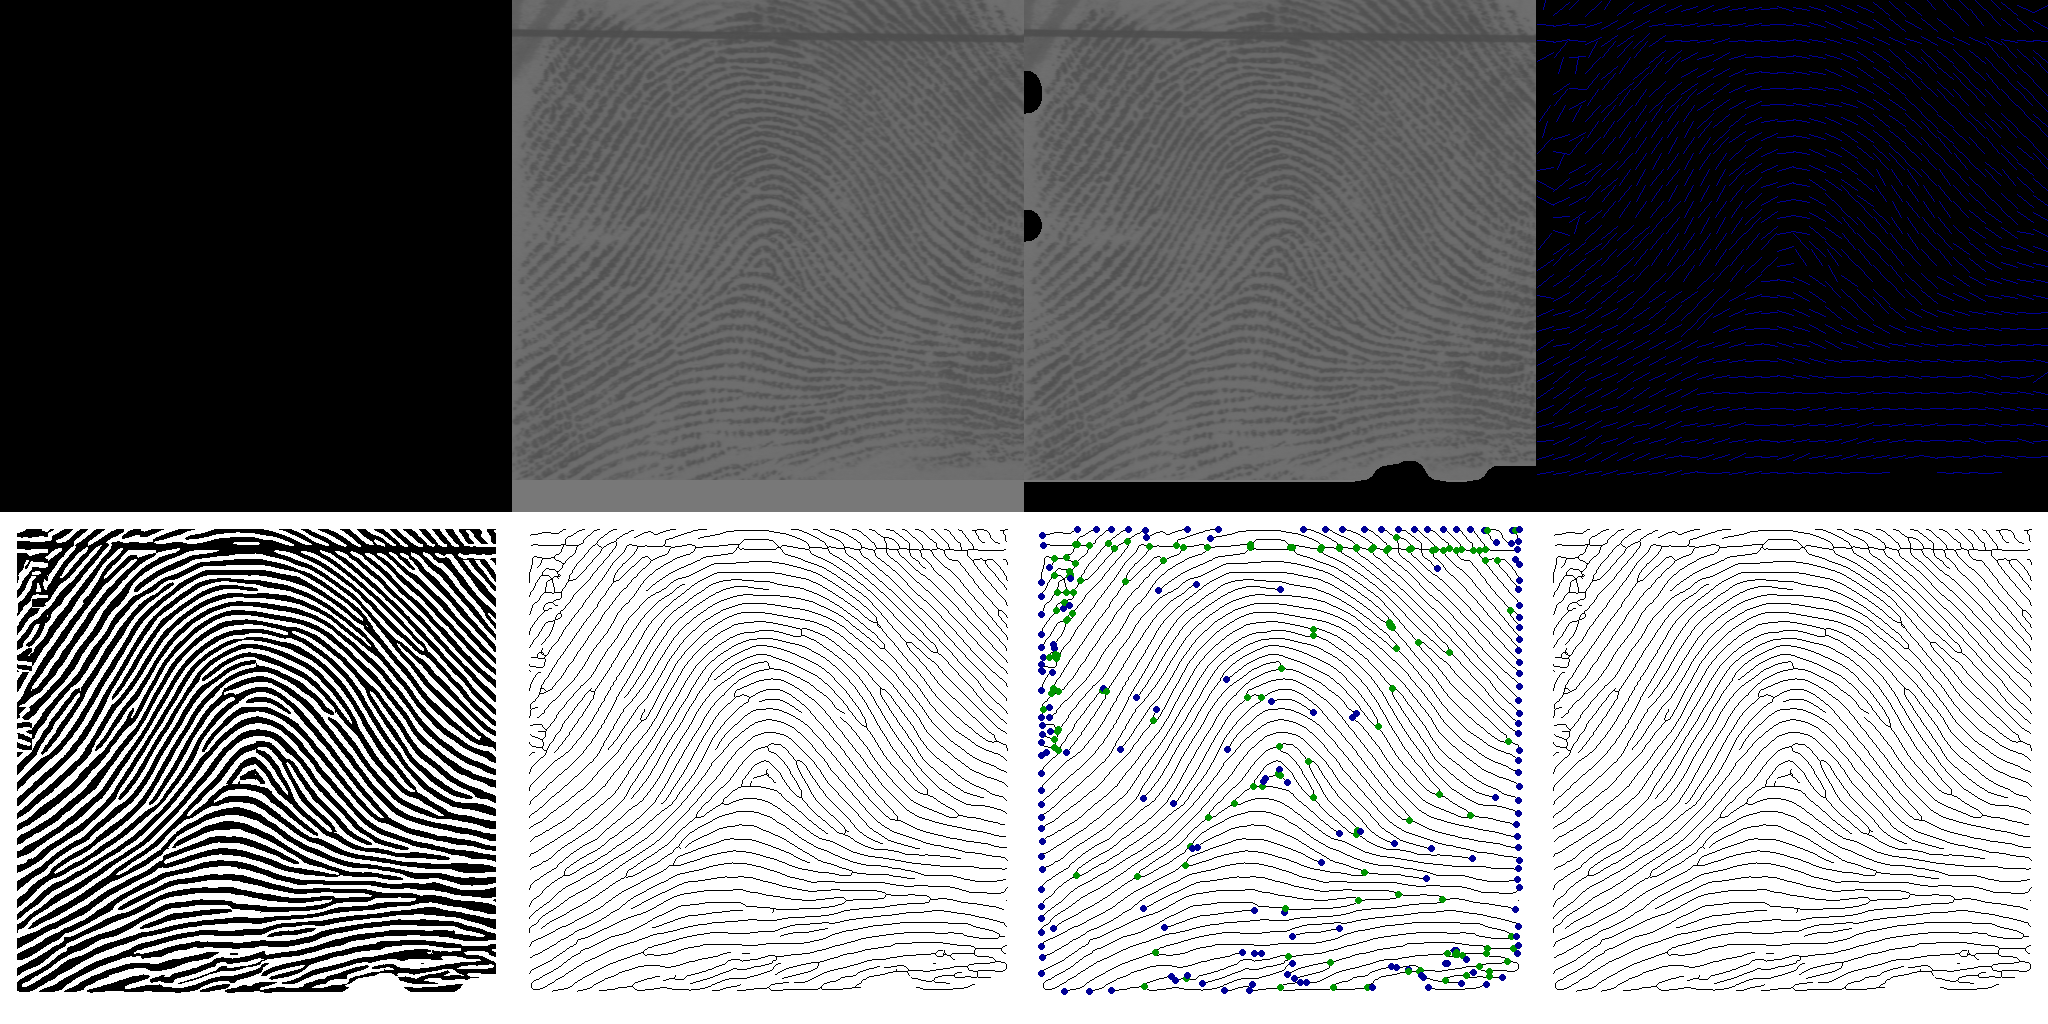

In [13]:
final_result = fingerprint_pipline(np.array(finger_image))
cv2_imshow(final_result)

---------------------------------------------------------------

# Exploratory Data Analysis

In [14]:
images = glob.glob('./drive/MyDrive/all_data/*.png')

#### Converting image to numpy array

In [18]:
def img2np(images, size = (64, 64)):
    # iterating through each file
    for img in images:
        # fp = path + fn
        current_image = image.load_img(img, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

#mat_images = img2np(images)

#### Finding distribution of all the classes

In [22]:
import os

A=0
L=0
R=0
T=0
W=0
for file in sorted(images):
  if file.startswith('./drive/MyDrive/all_data/A'):
    A = A+1
  elif file.startswith('./drive/MyDrive/all_data/L'):
    L = L+1
  elif file.startswith('./drive/MyDrive/all_data/R'):
    R = R+1
  elif file.startswith('./drive/MyDrive/all_data/T'):
    T = T+1
  elif file.startswith('./drive/MyDrive/all_data/W'):
    W = W+1

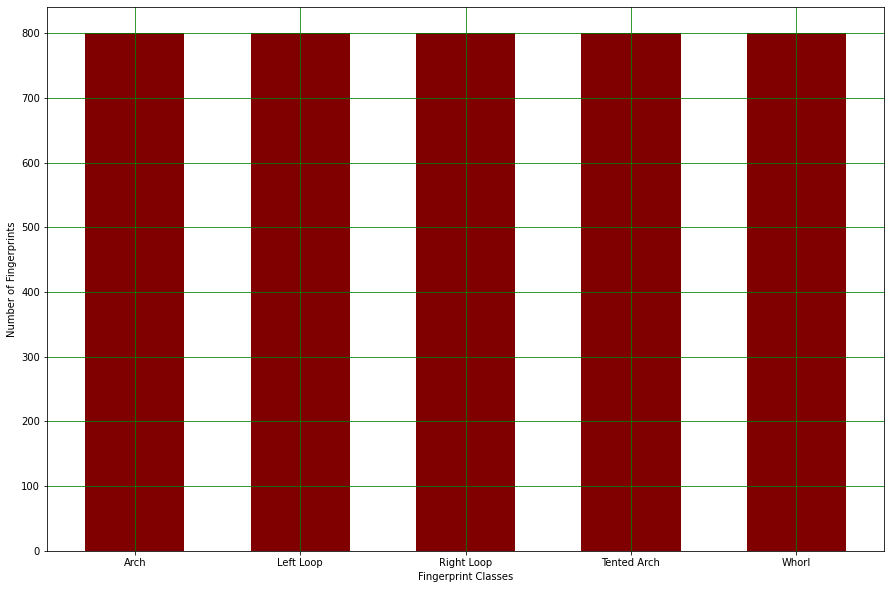

In [23]:
classes = ['Arch','Left Loop','Right Loop','Tented Arch','Whorl']
value = [A,L,R,T,W]

fig = plt.figure(figsize = (15, 10))
 
# creating the bar plot
plt.bar(classes, value, color ='maroon',
        width = 0.6)
 
plt.xlabel("Fingerprint Classes")
plt.ylabel("Number of Fingerprints")
# plt.title("Students enrolled in different courses")
plt.grid(color='green')
plt.show()

### The NIST-SD4 is a balanced dataset

---------------------------------------------------------------